In [41]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
import numpy as np
import matplotlib.pyplot as plt
from h5py import File
from astropy.cosmology import FlatLambdaCDM

import csiborgtools


%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read in upGLADE

- Mask out galaxies with bad redshifts
- Convert heliocentric redshifts to the CMB frame.

In [31]:
fname = "/mnt/users/rstiskalek/csiborgtools/data/upglade_z_0p05_all.h5"
data = {}
with File(fname, "r") as f:
    for i, key in enumerate(["RA", "dec", "zhelio", "e_zhelio"]):
        data[key] = f["data"]["block0_values"][:, i]

print(f"Initially, we have {data['zhelio'].size} objects.")

# Ask about this
mask = (data["e_zhelio"] < 0) | (data["zhelio"] < 0)
print(f"Masking {mask.sum()} objects that have `e_zhelio` < 0 or `zhelio` < 0.")
for key in data.keys():
    data[key][mask] = np.nan

mask = (data["e_zhelio"] / data["zhelio"] > 0.1) | (data["e_zhelio"] > 0.1) #& ~np.isnan(data["zhelio"])
print(f"Masking {mask.sum()} objects that have `e_zhelio` / `zhelio` > 0.1.")
for key in data.keys():
    data[key][mask] = np.nan

print(f"Finally, we have {np.sum(np.isfinite(data['zhelio']))} objects.")

Initially, we have 3313157 objects.
Masking 1174652 objects that have `e_zhelio` < 0 or `zhelio` < 0.
Masking 1714681 objects that have `e_zhelio` / `zhelio` > 0.1.
Finally, we have 423824 objects.


/tmp/ipykernel_1008842/393361353.py:15: RuntimeWarning: divide by zero encountered in divide
  mask = (data["e_zhelio"] / data["zhelio"] > 0.1) | (data["e_zhelio"] > 0.1) #& ~np.isnan(data["zhelio"])


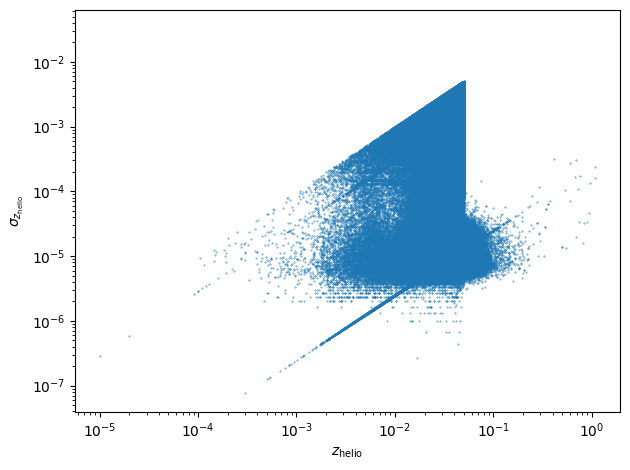

In [32]:
plt.figure()
plt.scatter(data["zhelio"], data["e_zhelio"], s=0.1)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$z_{\rm helio}$")
plt.ylabel(r"$\sigma_{z_{\rm helio}}$")

plt.tight_layout()
plt.show()

In [46]:
zcmb, e_zcmb = csiborgtools.heliocentric_to_cmb(data["zhelio"], data["RA"], data["dec"], data["e_zhelio"])
data["zcmb"] = zcmb
data["e_zcmb"] = e_zcmb


mask = (data["zcmb"] > 0.06) #& ~np.isnan(data["zhelio"])
print(f"Masking {mask.sum()} objects that have `zcmb` > 0.06.")
for key in data.keys():
    data[key][mask] = np.nan

print(f"Finally, we have {np.sum(np.isfinite(data['zhelio']))} objects.")

Masking 0 objects that have `zcmb` > 0.06.
Finally, we have 413314 objects.


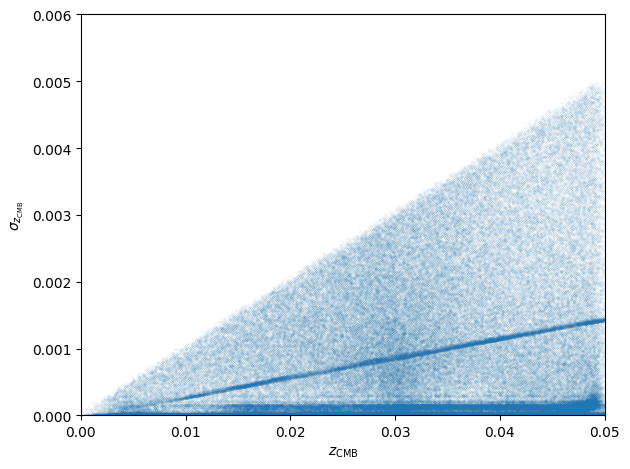

In [47]:
plt.figure()

plt.scatter(data["zcmb"], data["e_zcmb"], s=0.001)
plt.xlabel(r"$z_{\rm CMB}$")
plt.ylabel(r"$\sigma_{z_{\rm CMB}}$")

plt.xlim(0, 0.05)
plt.ylim(0, 0.006)

plt.tight_layout()
plt.show()

- Write only masked galaxies to this file, but also save the mask.

In [71]:
fname = "/mnt/users/rstiskalek/csiborgtools/data/upglade_z_0p05_all_PROCESSED.h5"
with File(fname, "w") as f:
    mask = np.isfinite(data["RA"])
    for key in data.keys():
        f[key] = data[key][mask]

    f["mask"] = mask

- Having generated this file, next step is to run `field_los.py` to evaluate the density and velocity field along the LOS of each object.

### Prepare external calibration data

- Based on Carrick2015 samples calibrated against Pantheon+

In [42]:
cosmo = FlatLambdaCDM(H0=100, Om0=0.3)

In [43]:
cosmo.comoving_distance(0.05)

<Quantity 148.19270311 Mpc>

In [39]:
def load_calibration(catalogue, simname, nsim, ksmooth):
    fname = f"/mnt/extraspace/rstiskalek/csiborg_postprocessing/peculiar_velocity/flow_samples_{catalogue}_{simname}_smooth_{ksmooth}.hdf5"  # noqa
    keys = ["Vext_x", "Vext_y", "Vext_z", "alpha", "beta", "sigma_v"]

    calibration_samples = {}
    with File(fname, 'r') as f:
        for key in keys:
            calibration_samples[key] = f[f"sim_{nsim}/{key}"][:][::10]

    return calibration_samples



calibration_samples = load_calibration("Pantheon+_zSN", "Carrick2015", 0, 0)





# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_mock_CB2_17417_large.hdf5"

simname = "csiborg2_main"
catalogue = "CB2_large"

nsims = paths.get_ics(simname)[:-1]
ksmooth = 1

loaders = []
models = []
zcosmo_mean = None
zobs = None

for i, nsim in enumerate(tqdm(nsims)):
    loader = csiborgtools.flow.DataLoader(simname, i, catalogue, fpath_data, paths, ksmooth=ksmooth)
    calibration_samples = load_calibration(catalogue, simname, nsim, ksmooth)
    model = csiborgtools.flow.Observed2CosmologicalRedshift(calibration_samples, loader.rdist, loader._Omega_m)

    if i == 0:
        zcosmo_mean = loader.cat["zcosmo"]
        zobs = loader.cat["zobs"]
        vrad = loader.cat["vrad"]

    loaders.append(loader)
    models.append(model)

In [ ]:
n = 400
zcosmo, pzcosmo = csiborgtools.flow.stack_pzosmo_over_realizations(
    n, models, loaders, "zobs")

In [ ]:
plt.figure()

# for i in range(len(nsims)):
    # mask = pzcosmo[i] > 1e-5
    # plt.plot(zcosmo[mask], pzcosmo[i][mask], color="black", alpha=0.1)

# mu = np.nanmean(pzcosmo, axis=0)
mask = pzcosmo > 1e-5
plt.plot(zcosmo[mask], pzcosmo[mask], color="black", label=r"$p(z_{\rm cosmo})$")

plt.ylim(0)
plt.axvline(zcosmo_mean[n], color="green", label=r"$z_{\rm cosmo}$")
plt.axvline(zobs[n], color="red", label=r"$z_{\rm CMB}$")

plt.xlabel(r"$z$")
plt.ylabel(r"$p(z)$")
plt.legend()
plt.tight_layout()
# plt.savefig("../plots/zcosmo_posterior_mock_example_B.png", dpi=450)
plt.show()